## Group Project "Boolean Pandemic"

### Predict who is more likely to survive to the pandemic

**Group:**
- Pedro Santos
- Lennart Dangers
- Federica Murillo
- Ana Claudia Alferes
- Alexandra Ordina

Link to Kaggle:


### Code structure:

* [1. Libraries](#lib)
* [2. Functions](#functions)
* [3. Data exploration](#explore)
* [4. Data pre-processing](#preprocess)
* [5. Feature engineering](#engineer)
* [6. Features comparison](#features)
* [7. Modelling](#model)
* [8. Finetuning](#finetune)
* [9. Test submission](#test)

## Dataset

**Data fields:**
    
- **Patient_ID** - The unique identifier of the patient
- **Family_Case_ID** - The family identification
- **Severity** - The severity of the disease, where 1 is the lowest and 3 the highest severity
- **Name** - The name of the patient
- **Birthday_year** - The year of birthday of the patient
- **Parents_Siblings_Infected** - The number of parents and/or siblings infected
- **Partner_Children_Infected** - The number of partner and/or children infected
- **Medical_Expenses_Family** - The medical expenses associated to try to contain the epidemy on the family
- **Medical_Tent** - The medical tent where the patient is / was lodged
- **City** - The original city of the patient
- **Deceased** - Flag if the patient deceased or not with the virus (0 = No, 1 = Yes)

<hr>
<a class="anchor" id="lib">

### 1. Libraries
    
</a>

In [316]:
#pip install xgboost
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV,LassoCV,RidgeCV, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import KNNImputer
from sklearn.svm import SVC, LinearSVC
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sb
import math
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn import metrics
import optuna
import functools

<hr>
<a class="anchor" id="functions">

### 2. Functions
    
</a>

In [317]:
def avg_score(model):
    # apply kfold
    kf = KFold(n_splits=5)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    n_iter = []
    for train_index, val_index in kf.split(X):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_val,y_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
        n_iter.append(model.n_iter_)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_iter = round(np.mean(n_iter),1)
    std_iter = round(np.std(n_iter),1)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test), str(avg_iter) + '+/-' + str(std_iter)

In [318]:
def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test, avg_iter = avg_score(arg)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test, avg_iter
        count+=1
    return df

In [319]:
def cor_heatmap(cor):
    plt.figure(figsize=(20,20))
    sb.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [320]:
def plt_box(data):
    n_col = 2
    n_row = 2
    fig, ax = plt.subplots(n_row, n_col, figsize=(15, 10))
    for var, subplot in zip(data[numerical], ax.flatten()):
        sb.boxplot(data[var], ax=subplot)

In [321]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [322]:
def split_scale(X,y,scale,size_test):
    """ This function scales the input dataset (X and y) and split both into train- and test sets
    Input: 
    X: Unscaled and unlabeled data
    y: The labels for X
    scale: choose between "StandardScaler", "MinMaxScaler" or "RobustScaler"
    size_test: size in percent of the test set 
    Output: X_train, X_test, y_train, y_test
    """
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=size_test,random_state=0,stratify =y)
    if scale == "RobustScaler":
        robust = RobustScaler().fit(X_train)
        X_train = robust.transform(X_train)
        X_test = robust.transform(X_test)
        return X_train, X_test,y_train,y_test
    elif scale == "MinMaxScaler":
        minmax = MinMaxScaler().fit(X_train)
        X_train = minmax.transform(X_train)
        X_test = minmax.transform(X_test)
        return X_train, X_test,y_train,y_test
    elif scale == "StandardScaler":
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        return X_train, X_test,y_train,y_test

In [323]:
def model_compare(list_of_models):
    train_score=[]
    val_score=[]
    model_used=[]
    for i in list_of_models:
        model = i
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        val_score.append(model.score(X_val, y_val))
        model_used.append(str(i))
        y_pred = model.predict(X_val)
    df = pd.DataFrame([model_used, train_score, val_score], index=["model","train_score","val_score"]).T.sort_values(by="val_score", ascending=False)
    return df

In [324]:
#function to remove outliers based on the IQR
def removeOutliers(df, cutoff1, features):
    
    outliers_to_remove = []
    for feature in features:
        if feature in df:
            #calculate interquartile range
            q25, q75 = np.nanpercentile(df[feature], 25), np.nanpercentile(df[feature], 75)
            iqr = q75 - q25
            print(feature)
            print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
        
            #calculate the outlier cutoff
            cut_off = iqr * cutoff1
            lower, upper = q25 - cut_off, q75 + cut_off
        
            #identify outliers
            outliers = [index for index, value in df[feature].iteritems() if value < lower or value > upper]
            print('Identified outliers: %d' % len(outliers))
            outliers_to_remove += outliers
    outliers_to_remove = set(outliers_to_remove)
    outliers_to_remove = sorted(outliers_to_remove)
    return outliers_to_remove

<hr>
<a class="anchor" id="explore">

### 3. Data exploration
    
</a>

### Full dataset exploration

In [325]:
Pandemic = pd.read_csv("train.csv")
Pandemic.describe(include='all')

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
count,900.000000,900.000000,900.000000,900,723.000000,900.000000,900.000000,900.000000,198,898,900.000000
unique,NaN,NaN,NaN,899,NaN,NaN,NaN,NaN,8,3,NaN
top,NaN,NaN,NaN,Mr. Samuel Darnell,NaN,NaN,NaN,NaN,C,Santa Fe,NaN
freq,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,57,649,NaN
mean,450.500000,14305.827778,2.313333,NaN,1990.266943,0.380000,0.521111,895.743333,NaN,NaN,0.614444
std,259.951919,25418.153900,0.834223,NaN,14.523335,0.803247,1.098385,1385.829926,NaN,NaN,0.486997
min,1.000000,345.000000,1.000000,NaN,1940.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
25%,225.750000,8203.000000,2.000000,NaN,1982.000000,0.000000,0.000000,221.000000,NaN,NaN,0.000000
50%,450.500000,13593.500000,3.000000,NaN,1992.000000,0.000000,0.000000,405.000000,NaN,NaN,1.000000
75%,675.250000,18906.500000,3.000000,NaN,1999.500000,0.000000,1.000000,861.250000,NaN,NaN,1.000000


In [326]:
# Check missing values
print(Pandemic.isnull().sum())

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64


In [327]:
Pandemic[Pandemic.Birthday_year != Pandemic.Birthday_year]

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
5,6,17598,2,Master Terrell Bob,NaN,0,0,0,NaN,Santa Fe,1
9,10,14392,3,Miss Elena Cathy,NaN,1,1,626,F,Albuquerque,0
14,15,6507,3,Miss Pearl Elsie,NaN,0,0,217,NaN,Taos,0
15,16,19174,3,Master Alfredo Marty,NaN,0,0,211,NaN,Santa Fe,1
20,21,24454,1,Miss Sara Lynne,NaN,0,1,3742,NaN,Santa Fe,0
21,22,6152,3,Miss Essie Katie,NaN,1,3,713,NaN,Santa Fe,1
23,24,19898,3,Miss Shirley Dawn,NaN,0,1,434,NaN,Taos,0
26,27,4274,2,Master Elias Wilson,NaN,0,0,0,NaN,Santa Fe,1
27,28,22832,3,Master Jeremiah Billy,NaN,0,0,217,F,Taos,1


**Initial considerations:**

We have 900 patients records
* one patient name repeats once but looking at the patients info we conclude these are two different people with same names
* Families can be tracked by Family_case_ID
* Birthday Year not available for everyone - fill in with KNNFiller? Also easier to work with age so will create a column "Age"(as of January 1st, 2020 when epidemic started)
* City has two missing values - fill in with KNNImputer?
* Medical tent can be unknown? (are there patients without tent or its data collection error?) so we cannot realy extrapolate these values and there are too many patients without Tent (almost 80%)
* Medical tent has many categories (8). This can indicate an issue with distribution. Can convert to binary (Tent - Yes-No).
* target value (deceased or not) is evenly distributed



In [328]:
# Exploration of categorical variables: cross table of Tents and city and severity of infection
table1 = pd.crosstab(index=Pandemic['City'], columns=Pandemic['Severity'])
table1

Severity,1,2,3
City,,,
Albuquerque,85,17,67
Santa Fe,127,165,357
Taos,2,4,74


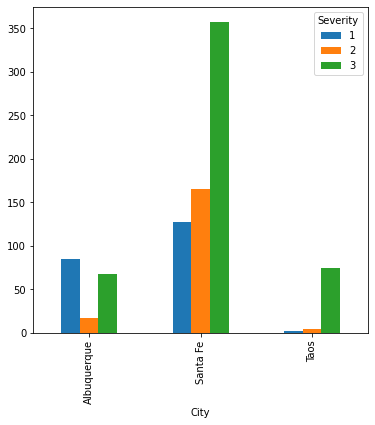

In [329]:
# Visual exploration of the cross table
table1.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=False)

In [330]:
table1 = pd.crosstab(index=Pandemic['Medical_Tent'], columns=Pandemic['Severity'])
table1

Severity,1,2,3
Medical_Tent,,,
A,15,0,0
B,46,0,0
C,56,0,1
D,27,4,0
E,24,4,3
F,0,8,5
G,0,0,4
T,1,0,0


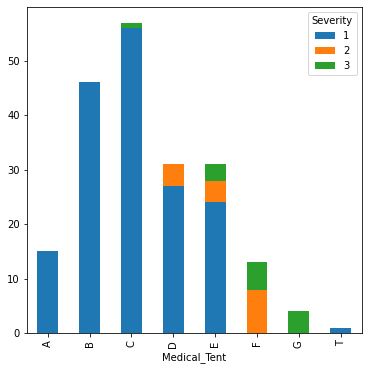

In [331]:
# Visual exploration of the cross table
table1.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

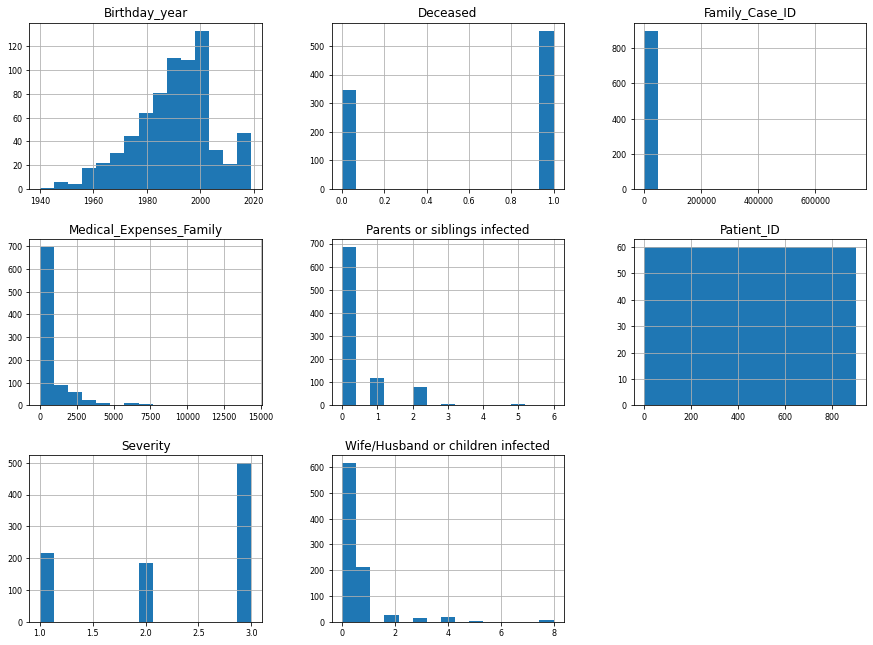

In [332]:
# Do histograms on all numeric variables
numerical=Pandemic.select_dtypes(include=[np.number]).columns.tolist()
Pandemic[numerical].hist(bins=15, figsize=(15, 15), layout=(4, 3), xlabelsize=8, ylabelsize=8);

Age has somewhat normal distribution, but Medical expenses need to be transformed. Also Infected family needs to be looked at.

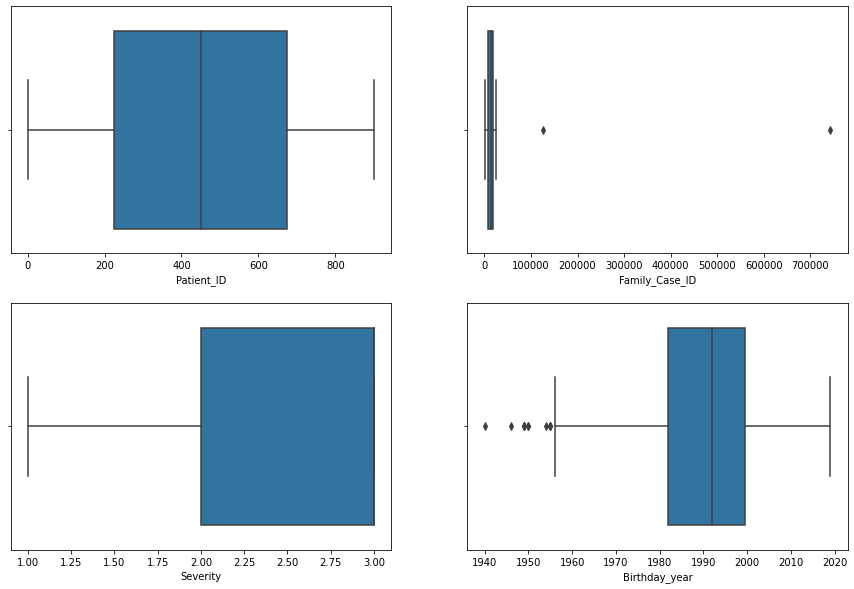

In [333]:
# Boxplots on all numeric variables
plt_box(Pandemic[numerical])

### Exploration of variables in relation to target

In [334]:
#average metrics for Deceased and Survivors to get initial insights
Pandemic.groupby('Deceased').mean()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family
Deceased,,,,,,,
0,449.423631,13619.536023,1.962536,1991.698305,0.463977,0.475504,1340.755043
1,451.175407,14736.466546,2.533454,1989.280374,0.327306,0.549729,616.504521


In [335]:
#Exploring categorical features
piv1=pd.pivot_table(Pandemic, values='Patient_ID', index=['City'], columns=['Deceased'],aggfunc='count')
piv2=pd.pivot_table(Pandemic, values='Patient_ID', index=['Severity'], columns=['Deceased'],aggfunc='count')
piv3=pd.pivot_table(Pandemic, values='Patient_ID', index=['Medical_Tent'], columns=['Deceased'],aggfunc='count')

display_side_by_side(piv1,piv2,piv3)


Deceased,0,1
City,,
Albuquerque,94,75
Santa Fe,221,428
Taos,30,50
Deceased,0,1
Severity,,
1,136,80
2,88,98
3,123,375
Deceased,0,1


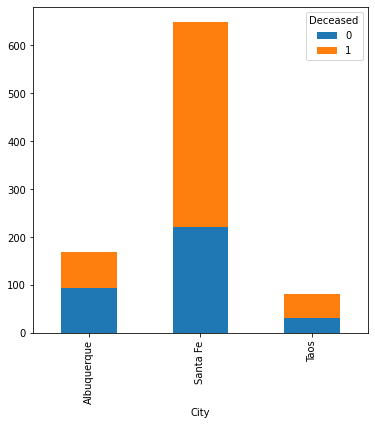

In [336]:
piv1.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

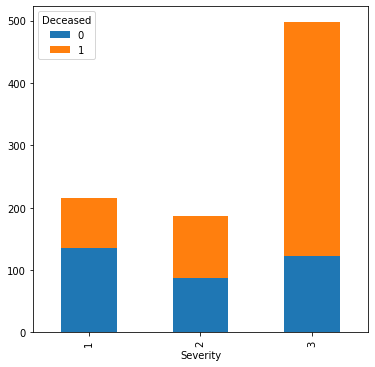

In [337]:
piv2.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

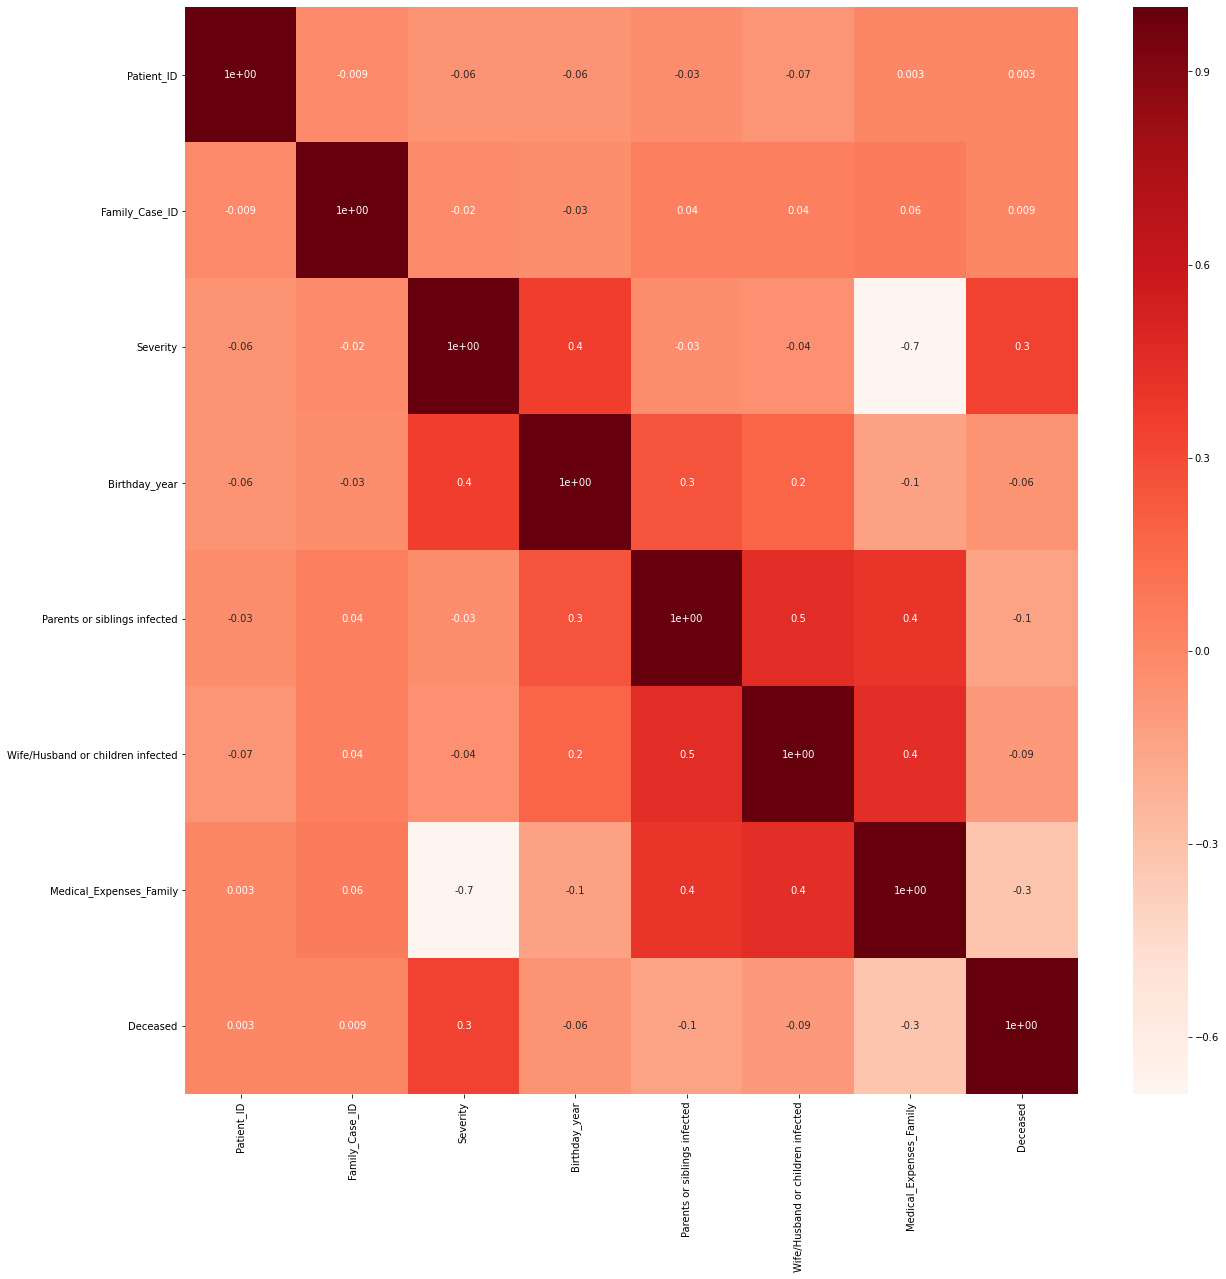

In [338]:
corr_df = Pandemic.corr('spearman')
cor_heatmap(corr_df)

In [339]:
abs(corr_df['Deceased']).sort_values(ascending=False)

Deceased                             1.000000
Severity                             0.334289
Medical_Expenses_Family              0.319579
Parents or siblings infected         0.140860
Wife/Husband or children infected    0.093854
Birthday_year                        0.058452
Family_Case_ID                       0.009041
Patient_ID                           0.003282
Name: Deceased, dtype: float64

**Some conclusions relating to target variable and input features**

* Family infected - younger patients die less, lower average in "Parents or siblings infected" can be explained by this. Also the two variables for infected in family seem to relay similar info so potentially can be merged into one feature "Family members infected" which reflects sum of the two columns
* Discard of "Medical_Tent" as almost 80% records do not have it or replace nulls with 9th category "No Tent"
* Create age variable
* Santa Fe has worst situation for severity of disease and number of infected, Albuquerque is next in number of infected but still has more people with lighter form of illness than the severe
* Survivors have spent more on medical expenses
* Severity, Medical expenses and Birthday Year are highly correlated.
* Partners/kids and parents/siblings are correlated

 **Severity, Medical expenses and infected family are most important features for the outcome of the illness**


<hr>
<a class="anchor" id="preprocess">

### 4. Data pre-processing
    
</a>

In [340]:
#dropping missing city
Pandemic.dropna(subset=['City'],axis=0,inplace=True)

#filling the missing Medical tent with "None"
Pandemic['Medical_Tent'].fillna('None',inplace=True)

#filling the missing Birthday Year with precicted values
imputer = KNNImputer(n_neighbors=3)
imputer.fit(Pandemic[['Birthday_year']])
Birthday_imputed = imputer.transform(Pandemic[['Birthday_year']])
Birthday_imputed = pd.DataFrame(Birthday_imputed, columns = Pandemic[['Birthday_year']].columns, index = Pandemic.index)
Birthday_imputed = Birthday_imputed.astype(int)
Pandemic = Pandemic.assign(Birthday_year=Birthday_imputed['Birthday_year'])

Pandemic.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,1990,0,0,225,None,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966,0,1,1663,None,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982,0,0,221,None,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997,0,0,220,None,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994,0,0,222,None,Santa Fe,0


In [341]:
#Check missing values in dataset
print(Pandemic.isnull().sum())

Patient_ID                           0
Family_Case_ID                       0
Severity                             0
Name                                 0
Birthday_year                        0
Parents or siblings infected         0
Wife/Husband or children infected    0
Medical_Expenses_Family              0
Medical_Tent                         0
City                                 0
Deceased                             0
dtype: int64


In [342]:
#create new variables age and Family infected 
Pandemic['Age']=2020-Pandemic['Birthday_year']
Pandemic.drop(['Birthday_year'],axis=1,inplace=True)

#create new variable Family_infected
#Pandemic['Family_infected']=Pandemic['Parents or siblings infected']+Pandemic['Wife/Husband or children infected']
#Pandemic.drop(['Parents or siblings infected','Wife/Husband or children infected'],axis=1,inplace=True)

In [343]:
#drop name column
#Pandemic.drop(['Name',"Patient_ID","Family_Case_ID"],axis=1,inplace=True)

#### Encoding categorical

In [344]:
# Encode categorical variables to dummy variables
import category_encoders as ce
encode = ['City', 'Medical_Tent']
ce_one_hot = ce.OneHotEncoder(cols = encode, use_cat_names=True)
encoded = ce_one_hot.fit_transform(Pandemic[encode])

complete = pd.concat([Pandemic, encoded], axis=1)
complete.drop(encode,axis=1,inplace=True)

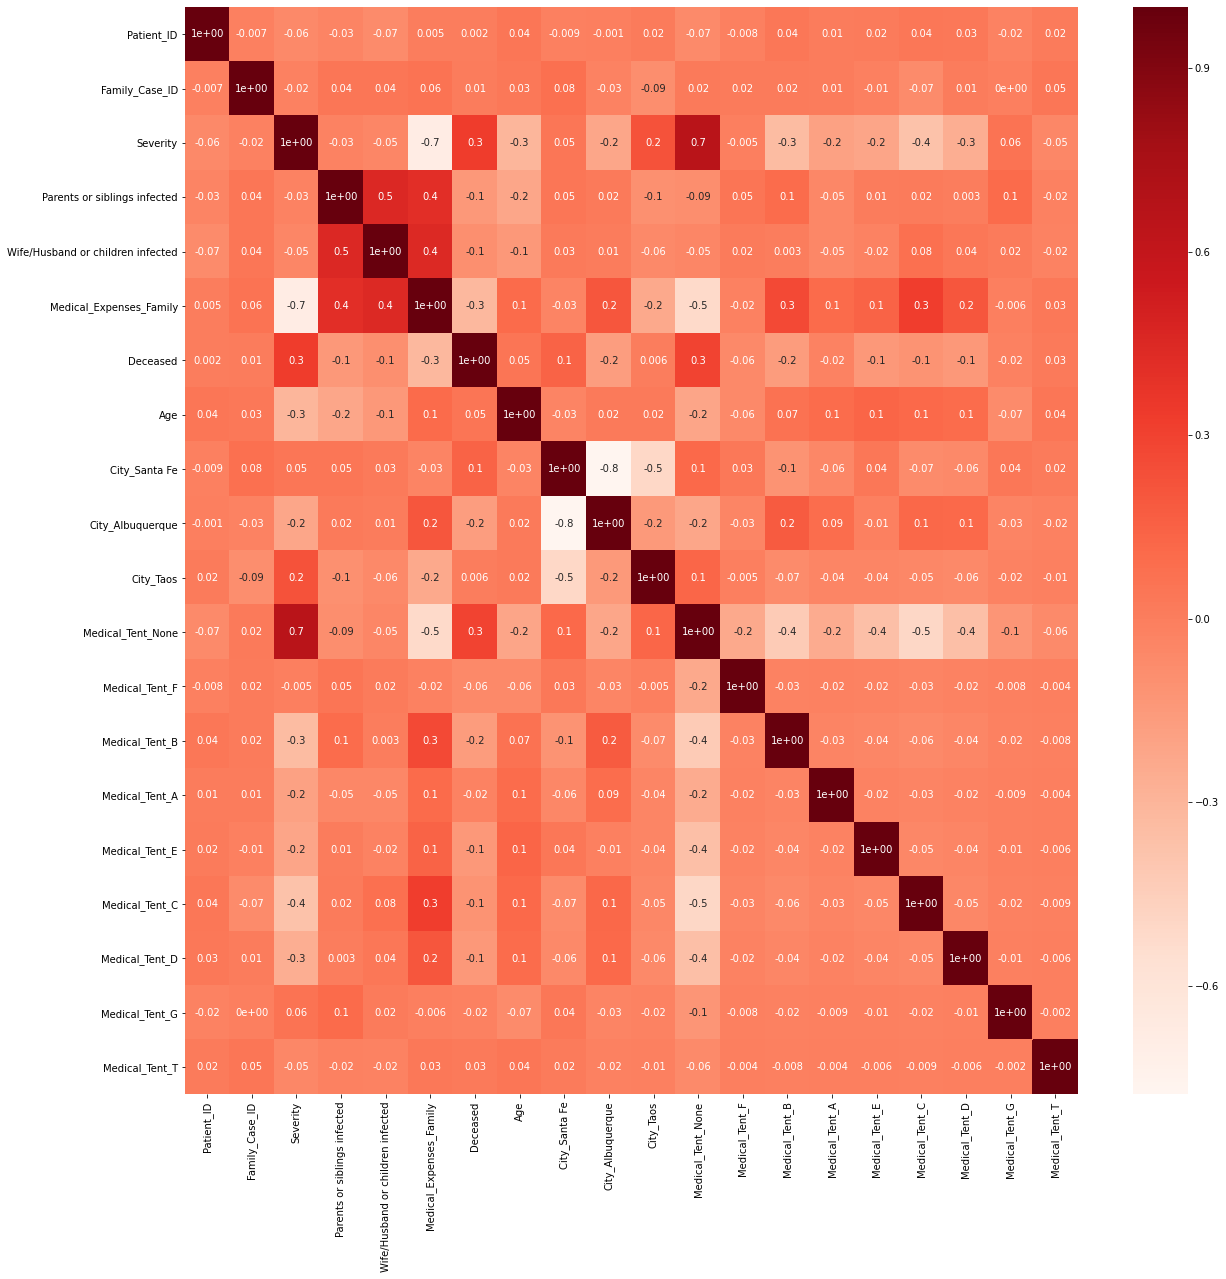

In [345]:
cor_heatmap(complete.corr('spearman'))

In [346]:
#complete.drop('City_Albuquerque', axis=1, inplace=True)

In [347]:
abs(complete.corr()['Deceased']).sort_values(ascending=False)

Deceased                             1.000000
Severity                             0.330357
Medical_Tent_None                    0.297630
Medical_Expenses_Family              0.252494
City_Albuquerque                     0.170286
Medical_Tent_B                       0.160105
City_Santa Fe                        0.144925
Medical_Tent_D                       0.139076
Medical_Tent_E                       0.139076
Medical_Tent_C                       0.113632
Parents or siblings infected         0.084364
Age                                  0.079661
Medical_Tent_F                       0.057609
Wife/Husband or children infected    0.031639
Medical_Tent_T                       0.026372
Family_Case_ID                       0.022422
Medical_Tent_A                       0.022101
Medical_Tent_G                       0.015927
City_Taos                            0.005907
Patient_ID                           0.001555
Name: Deceased, dtype: float64

<hr>
<a class="anchor" id="engineer">

### 5. Feature engineering
    
</a>

In [348]:
fe = complete.copy()

In [349]:
#logging expenses
fe["Medical_Expenses_Family_log"] = fe.Medical_Expenses_Family.apply(lambda x: np.log(x+1))

In [350]:
#new feature based on count of all family members both from test and train sets
Pandemic_test = pd.read_csv("test.csv")
Pandemic_test['Deceased'] = 0
fc_test=Pandemic_test[["Family_Case_ID","Deceased","Severity"]]
fc_train = fe[["Family_Case_ID","Deceased","Severity"]]
fc_all = pd.concat([fc_train,fc_test])
fc_all.head()



,Family_Case_ID,Deceased,Severity
0,4696,1,3
1,21436,0,1
2,7273,1,3
3,8226,1,3
4,19689,0,3


In [351]:
grouped_severity=fc_all[["Family_Case_ID","Severity"]].groupby(['Family_Case_ID']).mean()
grouped_severity.rename(columns={"Severity":"avgFamSeverity"},inplace=True)
grouped_severity.head()

,avgFamSeverity
Family_Case_ID,
345,2.0
981,3.0
1162,3.0
1681,2.0
1761,3.0


In [352]:
# Create a feature "Family_infected" to show how many members of family are infected
fcid = fc_all["Family_Case_ID"].value_counts()
fe = fe.merge(fcid, left_on="Family_Case_ID", right_on = fcid.index)
fe["Family_Infected"] = fe.Family_Case_ID_y - 1 #subtract the person
fe = fe.merge(grouped_severity, left_on="Family_Case_ID", right_on = grouped_severity.index)

In [353]:
# create a feature "Gender": If the name begins with Mr. or Master it is a male (encoded:0), if not, it is a female (encoded:1)
fe["NameSplit"]=fe.Name.str.rsplit()
fe["Gender"] = fe.NameSplit.apply(lambda x: 0 if x[0]=="Mr." or x[0]=="Master" else 
                                      (1))
fe.drop(columns=["NameSplit"],inplace=True)
fe.rename(columns={"Deceased_x":"Deceased"},inplace=True)


In [354]:
# Create a feature "dead_fam" to show how many members of family are dead
deceased_fam = pd.crosstab(fc_all.Family_Case_ID,fc_all.Deceased )[1] -1 #subtract the person
fe = fe.merge(deceased_fam, left_on = "Family_Case_ID", right_on = deceased_fam.index)
fe["dead_fam"] = fe[1].apply(lambda x : 0 if x<=0 else x)

fe.head()

,Family_Case_ID,Patient_ID,Family_Case_ID_x,Severity,Name,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Deceased,Age,...,Medical_Tent_D,Medical_Tent_G,Medical_Tent_T,Medical_Expenses_Family_log,Family_Case_ID_y,Family_Infected,avgFamSeverity,Gender,1,dead_fam
0,4696,1,4696,3,Miss Linda Betty,0,0,225,1,30,...,0,0,0,5.420535,1,0,3.0,1,0,0
1,21436,2,21436,1,Ms. Ramona Elvira,0,1,1663,0,54,...,0,0,0,7.416980,2,1,1.0,1,-1,0
2,7273,3,7273,3,Mr. Mario Vernon,0,0,221,1,38,...,0,0,0,5.402677,1,0,3.0,0,0,0
3,8226,4,8226,3,Mr. Hector Joe,0,0,220,1,23,...,0,0,0,5.398163,1,0,3.0,0,0,0
4,19689,5,19689,3,Ms. Jennie Debra,0,0,222,0,26,...,0,0,0,5.407172,1,0,3.0,1,-1,0


In [355]:
#fe is the full dataframe with additional features
#Split into data and target: X contains independent variables (before scaling) and y contains target
X = fe.copy()
y = X['Deceased']

In [356]:
X.drop(["Family_Case_ID","Patient_ID","Family_Case_ID_x","Deceased","Family_Case_ID_y","Name",1], axis=1, inplace=True)
X.head()

,Severity,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Age,City_Santa Fe,City_Albuquerque,City_Taos,Medical_Tent_None,Medical_Tent_F,...,Medical_Tent_E,Medical_Tent_C,Medical_Tent_D,Medical_Tent_G,Medical_Tent_T,Medical_Expenses_Family_log,Family_Infected,avgFamSeverity,Gender,dead_fam
0,3,0,0,225,30,1,0,0,1,0,...,0,0,0,0,0,5.420535,0,3.0,1,0
1,1,0,1,1663,54,0,1,0,1,0,...,0,0,0,0,0,7.416980,1,1.0,1,0
2,3,0,0,221,38,1,0,0,1,0,...,0,0,0,0,0,5.402677,0,3.0,0,0
3,3,0,0,220,23,1,0,0,1,0,...,0,0,0,0,0,5.398163,0,3.0,0,0
4,3,0,0,222,26,1,0,0,1,0,...,0,0,0,0,0,5.407172,0,3.0,1,0


#### Bin Age

In [357]:
#X['Age_label'] = pd.cut(x = X['Age'], bins = [0, 17, 29, 45, 59, 80, 110], labels = [0, 1, 2, 3, 4, 5])
#X['Age_label'] = pd.cut(x = X['Age'], bins = [0, 17, 29, 45, 59, 80, 110], labels = [0, 1, 2, 3, 4, 5])

In [358]:
#X['Age_label'] = X['Age_label'].astype('int')
#X['Age_label'] = X['Age_label'].astype('int')

<hr>
<a class="anchor" id="features">

### 6. Feature selection
    
</a>

In [359]:
### INSERT HERE THE SEVERAL DIFFERENT COMBINATIONS OF FEATURES TO DROP. KEEP ALL THE ITERATIONS.

todrop = ['Medical_Tent_A', 'Medical_Tent_None', 'Medical_Tent_G', 'Medical_Tent_F', 'Medical_Tent_T',
          'Wife/Husband or children infected', "Age_label", "Medical_Expenses_Family_log"]

todrop1 = ['Medical_Tent_A', 'Medical_Tent_None', 'Medical_Tent_G', 'Medical_Tent_F', 'Medical_Tent_T',
          'Wife/Husband or children infected', "Medical_Expenses_Family"]

todrop2 = ["Medical_Expenses_Family","Medical_Tent_T", "dead_fam"]

In [360]:
#drop variables based on low correlations with target and high mutual correlations
X.drop(todrop2,axis=1,inplace=True)

In [361]:
X_temp = X.copy()

In [362]:
scaler = StandardScaler().fit(X_temp)
X_temp= pd.DataFrame(scaler.transform(X_temp),columns=X_temp.columns)

### RFE

In [363]:
model = LogisticRegression()
rfe = RFE(estimator = model)
X_rfe = rfe.fit_transform(X = X_temp, y = y)
model.fit(X=X_temp, y = y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [364]:
rfe.ranking_

array([ 1,  7,  1,  1,  1,  9, 11,  3,  1,  2,  5,  1,  4,  1, 10,  1,  8,
        6,  1])

In [365]:
selected_features = pd.Series(rfe.support_, index = X_temp.columns)
rfe_features = selected_features.index.tolist()
selected_features

Severity                              True
Parents or siblings infected         False
Wife/Husband or children infected     True
Age                                   True
City_Santa Fe                         True
City_Albuquerque                     False
City_Taos                            False
Medical_Tent_None                    False
Medical_Tent_F                        True
Medical_Tent_B                       False
Medical_Tent_A                       False
Medical_Tent_E                        True
Medical_Tent_C                       False
Medical_Tent_D                        True
Medical_Tent_G                       False
Medical_Expenses_Family_log           True
Family_Infected                      False
avgFamSeverity                       False
Gender                                True
dtype: bool

## Lasso Regression

In [366]:
reg = LassoCV()
reg.fit(X=X_temp, y=y)
print("Best alpha: %f" % reg.alpha_)

Best alpha: 0.019861


In [367]:
coef = pd.Series(reg.coef_, index=X_temp.columns)
lasso_features = coef[coef != 0].index.tolist()
coef.sort_values()

Gender                              -0.221284
Medical_Expenses_Family_log         -0.015028
Medical_Tent_E                      -0.006866
City_Albuquerque                    -0.004951
Family_Infected                      0.000000
Medical_Tent_G                       0.000000
Medical_Tent_D                      -0.000000
Medical_Tent_C                       0.000000
Medical_Tent_A                      -0.000000
Medical_Tent_B                      -0.000000
Medical_Tent_F                      -0.000000
City_Taos                           -0.000000
Parents or siblings infected         0.000000
avgFamSeverity                       0.000000
City_Santa Fe                        0.007119
Wife/Husband or children infected    0.026085
Medical_Tent_None                    0.031774
Age                                  0.044220
Severity                             0.092487
dtype: float64

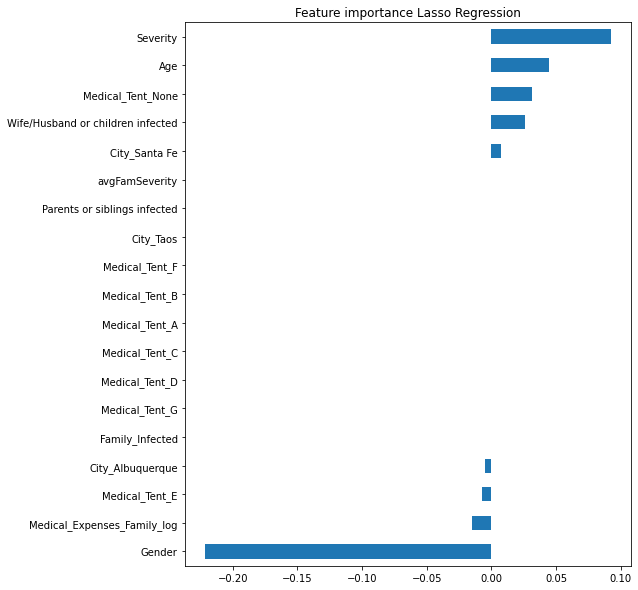

In [368]:
coef=coef.sort_values()
plt.figure(figsize=(8,10))
coef.plot(kind = "barh")
plt.title("Feature importance Lasso Regression")
plt.show()

## Ridge Regression

In [369]:
ridge = RidgeCV()
ridge.fit(X=X_temp, y=y)
coef_ridge = pd.Series(ridge.coef_,index=X_temp.columns)
coef_ridge

Severity                             0.105396
Parents or siblings infected         0.016185
Wife/Husband or children infected    0.049359
Age                                  0.078557
City_Santa Fe                        0.012485
City_Albuquerque                    -0.011162
City_Taos                           -0.004304
Medical_Tent_None                   -0.007236
Medical_Tent_F                      -0.026788
Medical_Tent_B                      -0.021865
Medical_Tent_A                      -0.016167
Medical_Tent_E                      -0.041714
Medical_Tent_C                      -0.009900
Medical_Tent_D                      -0.031331
Medical_Tent_G                       0.008634
Medical_Expenses_Family_log         -0.040973
Family_Infected                      0.004822
avgFamSeverity                      -0.005607
Gender                              -0.234331
dtype: float64

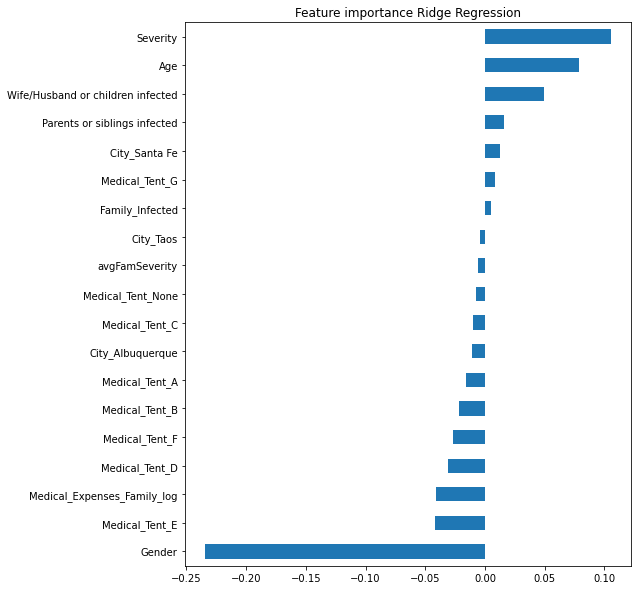

In [370]:
coef=coef_ridge.sort_values()
plt.figure(figsize=(8,10))
coef.plot(kind = "barh")
plt.title("Feature importance Ridge Regression")
plt.show()

## Feature Importance Random Forest 

In [371]:
clf=RandomForestClassifier()
clf.fit(X_temp,y)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<Figure size 576x720 with 0 Axes>

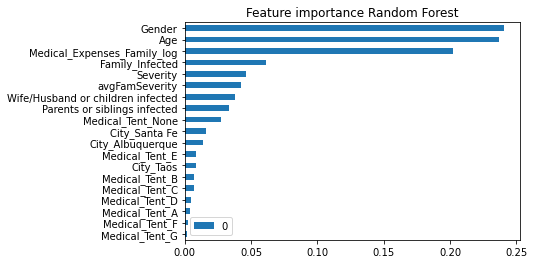

In [372]:
fi=pd.DataFrame(clf.feature_importances_, index=X_temp.columns).sort_values(by=0)
plt.figure(figsize=(8,10))
fi.plot(kind = "barh")
plt.title("Feature importance Random Forest")
plt.show()

### Drop features

In [373]:
X = X[lasso_features]

In [374]:
X.columns

Index(['Severity', 'Wife/Husband or children infected', 'Age', 'City_Santa Fe',
       'City_Albuquerque', 'Medical_Tent_None', 'Medical_Tent_E',
       'Medical_Expenses_Family_log', 'Gender'],
      dtype='object')

<hr>
<a class="anchor" id="model">

### 7. Modelling
    
</a>

## Train and Validation Normalized

In [375]:
X_train, X_val,y_train,y_val = split_scale(X,y,"StandardScaler",0.3)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)

## Classifier

In [376]:
model_list = [MLPClassifier(),LogisticRegression(),RandomForestClassifier(),
              KNeighborsClassifier(), GradientBoostingClassifier(),GaussianNB(),
              LogisticRegressionCV(),RidgeClassifier(),SVC(), LinearSVC(), XGBClassifier(), AdaBoostClassifier()]

model_compare(model_list)

,model,train_score,val_score
4,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.894904,0.825926
8,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.842357,0.825926
0,"MLPClassifier(activation='relu', alpha=0.0001,...",0.861465,0.822222
2,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.980892,0.818519
7,"RidgeClassifier(alpha=1.0, class_weight=None, ...",0.797771,0.814815
9,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.802548,0.811111
10,"XGBClassifier(base_score=0.5, booster=None, co...",0.976115,0.811111
1,"LogisticRegression(C=1.0, class_weight=None, d...",0.791401,0.8
3,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.855096,0.8
6,"LogisticRegressionCV(Cs=10, class_weight=None,...",0.791401,0.8


In [377]:
#creating instance of XGB Classifier to finetune
model = GradientBoostingClassifier()
model.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [378]:
print(classification_report(y_val, model.predict(X_val)))
print(confusion_matrix(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       104
           1       0.85      0.87      0.86       166

    accuracy                           0.83       270
   macro avg       0.82      0.81      0.81       270
weighted avg       0.82      0.83      0.83       270

[[ 78  26]
 [ 21 145]]


<hr>
<a class="anchor" id="finetune">

### 8. Finetuning
    
</a>

In [379]:
#source https://www.kaggle.com/snakayama/xgboost-using-optuna
def optxgb(X_train, y_train, X_test, y_test, trial):
    #param_list
    n_estimators = trial.suggest_int('n_estimators', 0, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 40)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.001, 0.2, 0.001)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    reg_lambda = trial.suggest_discrete_uniform('reg_lambda', 0, 1, 0.001)
    reg_alpha = trial.suggest_discrete_uniform('reg_alpha', 0, 1, 0.001)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)

    xgboost_tuna = XGBClassifier(
        random_state=1, 
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        learning_rate = learning_rate,
        subsample = subsample,
        reg_lambda = reg_lambda,
        reg_alpha = reg_alpha,
        colsample_bytree = colsample_bytree,
    )
    xgboost_tuna.fit(X_train, y_train)
    tuna_pred_test = xgboost_tuna.predict(X_val)
    
    return (metrics.accuracy_score(y_test, tuna_pred_test))

#source https://www.kaggle.com/snakayama/xgboost-using-optuna
def optmlp(X_train, y_train, X_test, y_test, trial):
    #param_list
    activation = trial.suggest_categorical('activation', ['relu', 'logistic', 'tanh'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd','lbfgs'])
    batch_size = trial.suggest_int('batch_size', 100, 600, 100)
    max_iter = trial.suggest_int('max_iter', 100, 1000, 100)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant','adaptive'])
    learning_rate_init = trial.suggest_discrete_uniform('learning_rate_init', 0.001, 0.1, 0.001)
    alpha = trial.suggest_discrete_uniform('alpha', 0.001, 0.2, 0.001)
    
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 1, 30))
    
    MLP_model = MLPClassifier(
        random_state=1, 
        alpha = alpha,
        activation = activation,
        solver=solver,
        batch_size = batch_size,
        max_iter= max_iter,
        learning_rate = learning_rate,
        learning_rate_init = learning_rate_init,
        hidden_layer_sizes=tuple(layers)
    )
    MLP_model.fit(X_train, y_train)
    tuna_pred_test = MLP_model.predict(X_test)
    
    return (metrics.accuracy_score(y_test, tuna_pred_test))

def opt_gdb(X_train, y_train, X_test, y_test, trial):
    #param_list
    n_estimators = trial.suggest_int('n_estimators', 1, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 40)
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.001, 0.2, 0.001)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    loss=trial.suggest_categorical('loss', ['deviance', 'exponential'])
    min_samples_split=trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20)
    min_weight_fraction_leaf=trial.suggest_discrete_uniform('min_weight_fraction_leaf', 0, 0.5, 0.001)
    max_features=trial.suggest_int('max_features', 1, len(X_train.columns))
    #max_leaf_nodes=trial.suggest_int('max_leaf_nodes', 2, 1000)
    
    gb_tuna = GradientBoostingClassifier(
        random_state=1, 
        n_estimators = n_estimators,
        max_depth = max_depth,
        learning_rate = learning_rate,
        subsample = subsample,
        loss=loss,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_features=max_features,
        #max_leaf_nodes=max_leaf_nodes,
 
    )
    gb_tuna.fit(X_train, y_train)
    tuna_pred_test = gb_tuna.predict(X_val)
    
    return (metrics.accuracy_score(y_test, tuna_pred_test))


In [ ]:
opt = opt_gdb
study = optuna.create_study(direction = 'maximize')
study.optimize(functools.partial(opt, X_train, y_train, X_val, y_val), n_trials=100)

[I 2020-05-22 15:54:24,099] Finished trial#0 with value: 0.6925925925925925 with parameters: {'n_estimators': 682, 'max_depth': 17, 'learning_rate': 0.048, 'subsample': 0.6, 'loss': 'exponential', 'min_samples_split': 13, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.46900000000000003, 'max_features': 9}. Best is trial#0 with value: 0.6925925925925925.
[I 2020-05-22 15:54:24,461] Finished trial#1 with value: 0.6185185185185185 with parameters: {'n_estimators': 588, 'max_depth': 28, 'learning_rate': 0.035, 'subsample': 0.8, 'loss': 'deviance', 'min_samples_split': 14, 'min_samples_leaf': 12, 'min_weight_fraction_leaf': 0.482, 'max_features': 1}. Best is trial#0 with value: 0.6925925925925925.
[I 2020-05-22 15:54:24,974] Finished trial#2 with value: 0.7925925925925926 with parameters: {'n_estimators': 695, 'max_depth': 16, 'learning_rate': 0.2, 'subsample': 0.6, 'loss': 'deviance', 'min_samples_split': 8, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.28400000000000003, 'max

[I 2020-05-22 15:54:45,549] Finished trial#46 with value: 0.8148148148148148 with parameters: {'n_estimators': 954, 'max_depth': 14, 'learning_rate': 0.057, 'subsample': 0.5, 'loss': 'deviance', 'min_samples_split': 14, 'min_samples_leaf': 18, 'min_weight_fraction_leaf': 0.108, 'max_features': 7}. Best is trial#41 with value: 0.8444444444444444.
[I 2020-05-22 15:54:46,171] Finished trial#47 with value: 0.8222222222222222 with parameters: {'n_estimators': 867, 'max_depth': 11, 'learning_rate': 0.045, 'subsample': 0.6, 'loss': 'deviance', 'min_samples_split': 17, 'min_samples_leaf': 20, 'min_weight_fraction_leaf': 0.216, 'max_features': 6}. Best is trial#41 with value: 0.8444444444444444.
[I 2020-05-22 15:54:46,752] Finished trial#48 with value: 0.6777777777777778 with parameters: {'n_estimators': 921, 'max_depth': 17, 'learning_rate': 0.032, 'subsample': 0.7, 'loss': 'deviance', 'min_samples_split': 12, 'min_samples_leaf': 17, 'min_weight_fraction_leaf': 0.384, 'max_features': 8}. Best 

In [ ]:
study.best_params

### Final classifier

In [ ]:
#fitting scale on full X dataframe
scaler_final = StandardScaler().fit(X)
X_train = pd.DataFrame(scaler_final.transform(X),columns=X.columns)


In [ ]:
#fitting best performing model on full X dataframe
GBCmodel = GradientBoostingClassifier(**study.best_params,random_state=150) 
GBCmodel.fit(X_train,y)
GBCmodel.score(X_train,y)

In [ ]:
#features used
X.columns

### version 1 - Removing the outliers

In [160]:
#fe1 is the new df after removing outliers
# Selecting 3 IQR to remove the most extreme outliers in age and med expenses
features = ['Age', 'Medical_Expenses_Family']
outliers_index = removeOutliers(fe, 3, features)

# Removing outliers
fe1=fe.drop(outliers_index)
fe1.reset_index(inplace=True, drop=True)

Age
Percentiles: 25th=22.000, 75th=35.000, IQR=13.000
Identified outliers: 1
Medical_Expenses_Family
Percentiles: 25th=221.000, 75th=857.750, IQR=636.750
Identified outliers: 53


In [161]:
fe1.drop(["Family_Case_ID","Patient_ID","Family_Case_ID_x","Family_Case_ID_y","Name",1], axis=1, inplace=True)
todrop2 = ["Medical_Expenses_Family",'Medical_Tent_T']
fe1.drop(todrop2,axis=1,inplace=True)

In [162]:
#results with dropping outliers
X = fe1.drop(['Deceased'], axis=1)
X = X[lasso_features]
y = fe1['Deceased']
X_train, X_val,y_train,y_val = split_scale(X,y,"StandardScaler",0.3)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)

model_compare(model_list)

,model,train_score,val_score
4,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.918644,0.862205
1,"LogisticRegression(C=1.0, class_weight=None, d...",0.855932,0.84252
6,"LogisticRegressionCV(Cs=10, class_weight=None,...",0.857627,0.84252
9,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.861017,0.84252
2,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.979661,0.838583
10,"XGBClassifier(base_score=0.5, booster=None, co...",0.974576,0.838583
0,"MLPClassifier(activation='relu', alpha=0.0001,...",0.898305,0.834646
8,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.852542,0.822835
7,"RidgeClassifier(alpha=1.0, class_weight=None, ...",0.849153,0.814961
3,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.871186,0.811024


### Final classifier1 (outliers removed)

In [309]:
#fitting scale on full X dataframe
scaler_final = StandardScaler().fit(X)
X_train = pd.DataFrame(scaler_final.transform(X),columns=X.columns)

#fitting best performing model on full X dataframe
GBCmodel = GradientBoostingClassifier(**study.best_params,random_state=150) 
GBCmodel.fit(X_train,y)
GBCmodel.score(X_train,y)

0.8830734966592427

In [310]:
gbcols= pd.Series(GBCmodel.feature_importances_, index = X_train.columns)
gbcols = gbcols[gbcols != 0]
gbcols= gbcols.index.tolist()

# Test Dataset - submission

### Same pre-processing as Train

In [311]:
Pandemic_test = pd.read_csv("test.csv")

Pandemic_test

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City
0,901,49242,3,Mr. Jody Pedro,NaN,0,0,203,NaN,Santa Fe
1,902,10400,3,Mr. Kevin Brent,1988.0,0,0,631,NaN,Santa Fe
2,903,10795,3,Mr. Frankie Cary,1981.0,1,0,376,NaN,Albuquerque
3,904,62440,3,Mr. Rick Pete,NaN,0,1,405,NaN,Albuquerque
4,905,81311,2,Mr. Matthew Erick,1996.0,0,0,378,NaN,Santa Fe
5,906,128471,2,Mr. Bryan Santiago,1994.0,0,0,364,NaN,Santa Fe
6,907,24058,3,Mr. Tom Miguel,2002.0,0,1,405,NaN,Albuquerque
7,908,54346,3,Mrs. Lucia Angelica,1985.0,0,0,217,NaN,Taos
8,909,23128,2,Mr. Allan Vincent,1980.0,0,0,364,NaN,Santa Fe
9,910,71576,3,Mrs. Lela Judy,1982.0,0,0,202,NaN,Albuquerque


In [312]:

#filling Medical tent
Pandemic_test['Medical_Tent'].fillna('None',inplace=True)

#filling in missing birthday year
Birthday_imputed_test =imputer.transform(Pandemic_test[['Birthday_year']])
Birthday_imputed_test = pd.DataFrame(Birthday_imputed_test, columns = Pandemic_test[['Birthday_year']].columns, index = Pandemic_test.index)
Birthday_imputed_test = Birthday_imputed_test.astype(int)
Pandemic_test = Pandemic_test.assign(Birthday_year=Birthday_imputed_test['Birthday_year'])

#replacing year with age feature
Pandemic_test['Age']=2020-Pandemic_test['Birthday_year']
Pandemic_test.drop(['Birthday_year'],axis=1,inplace=True)

#encoding categorical
encode = ['City', 'Medical_Tent']
encoded = ce_one_hot.fit_transform(Pandemic_test[encode])
Pandemic_test = pd.concat([Pandemic_test, encoded], axis=1)
Pandemic_test.drop(encode,axis=1,inplace=True)


#complete_test.drop('City_Albuquerque', axis=1, inplace=True)

#adding features (logging Med expenses, Family infected, fam_dead)
Pandemic_test["Medical_Expenses_Family_log"] = Pandemic_test.Medical_Expenses_Family.apply(lambda x: np.log(x+1))

#"Gender": If the name begins with Mr. or Master it is a male (encoded:0), if not, it is a female (encoded:1)
Pandemic_test["NameSplit"]=Pandemic_test.Name.str.rsplit()
Pandemic_test["Gender"] = Pandemic_test.NameSplit.apply(lambda x: 0 if x[0]=="Mr." or x[0]=="Master" else(1))
Pandemic_test.drop(columns="NameSplit",inplace=True)

#family infected
Pandemic_test = Pandemic_test.merge(fcid, left_on="Family_Case_ID", right_on = fcid.index)
Pandemic_test["Family_Infected"] = Pandemic_test.Family_Case_ID_y - 1 #subtract the person
Pandemic_test = Pandemic_test.merge(grouped_severity, left_on="Family_Case_ID", right_on = grouped_severity.index)



#fam_dead
Pandemic_test = Pandemic_test.merge(deceased_fam, left_on = "Family_Case_ID", right_on = deceased_fam.index)

Pandemic_test["dead_fam"] = Pandemic_test[1].apply(lambda x : 0 if x<=0 else x)

Pandemic_test.rename(columns={"avgFamSeverity_x":"avgFamSeverity"}, inplace=True)

#extracting Patient IDs
Patient_ID=pd.DataFrame(Pandemic_test["Patient_ID"])


In [313]:

#dropping features
Pandemic_test.drop(["Family_Case_ID","Patient_ID","Family_Case_ID_x","Family_Case_ID_y","Name",1], axis=1, inplace=True)
todrop2 = ["Medical_Expenses_Family","dead_fam"]
Pandemic_test.drop(todrop2,axis=1,inplace=True)
X_test = Pandemic_test.copy()

X_test = X_test[lasso_features]

#scaling
X_test = pd.DataFrame(scaler_final.transform(X_test),columns=X_test.columns)

### Prediction

In [314]:
y_pred = pd.DataFrame(GBCmodel.predict(X_test))
y_pred = y_pred.merge(Patient_ID, left_index = True , right_index = True)
y_pred = y_pred[['Patient_ID', 0]].sort_values(by="Patient_ID")
y_pred.rename(columns = {0 : "Deceased"}, inplace = True)
#y_pred.to_csv('sub_lassof3.csv', index = False)